In [ ]:
! pip install tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 2.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import json
import os
import tempfile
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tf_keras as keras
import tensorflow_model_optimization as tfmot
import matplotlib.pyplot as plt
from tensorflow_model_optimization.python.core.sparsity.keras import prune
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/dataset/data.json"

Mounted at /content/drive


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 455)               0         
                                                                 
 dense (Dense)               (None, 256)               116736    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

/usr/local/lib/python3.10/dist-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


  1/104 [..............................] - ETA: 5:31 - loss: 0.4299 - accuracy: 0.8438

104/104 [==============================] - 4s 9ms/step - loss: 0.5583 - accuracy: 0.7846 - val_loss: 2.0248 - val_accuracy: 0.2112
Epoch 2/50
104/104 [==============================] - 1s 10ms/step - loss: 1.6023 - accuracy: 0.2218 - val_loss: 1.5376 - val_accuracy: 0.2343
Epoch 3/50
104/104 [==============================] - 1s 10ms/step - loss: 1.4937 - accuracy: 0.2726 - val_loss: 1.3970 - val_accuracy: 0.3433
Epoch 4/50
104/104 [==============================] - 1s 11ms/step - loss: 1.4214 - accuracy: 0.3556 - val_loss: 1.2962 - val_accuracy: 0.4646
Epoch 5/50
104/104 [==============================] - 1s 11ms/step - loss: 1.3570 - accuracy: 0.4109 - val_loss: 1.2186 - val_accuracy: 0.5109
Epoch 6/50
104/104 [==============================] - 1s 9ms/step - loss: 1.3242 - accuracy: 0.4329 - val_loss: 1.1731 - val_accuracy: 0.5381
Epoch 7/50
104/104 [==============================] - 1s 6ms/step - loss: 1.2800 - accuracy: 0.4586 - val_loss: 1.1051 - val_accuracy: 0.5763
Epoch 8/50
10

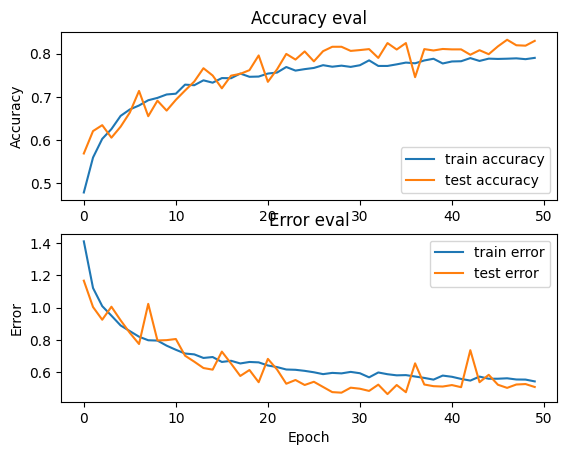

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 35, 13], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_2'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

In [ ]:
def load_data(dataset_path):
  with open(dataset_path, "r") as fp:
    data = json.load(fp)

  inputs = np.array(data["mfcc"]) # converte le liste delle mfcc in vettori
  targets = np.array(data["labels"]) # converte le liste delle labels in vettori

  return inputs, targets

def plot_history(history):
  fig, axs = plt.subplots(2)
  axs[0].plot(history.history["accuracy"], label="train accuracy") # subplot dell'accuratezza del training
  axs[0].plot(history.history["val_accuracy"], label="test accuracy") # subplot dell'accuratezza del test
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")

  axs[1].plot(history.history["loss"], label="train error") # subplot dell'errore del training
  axs[1].plot(history.history["val_loss"], label="test error") # subplot dell'errore del test
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")
  plt.show()

if __name__=="__main__":
  inputs, targets = load_data(DATASET_PATH)
  inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.3)
  # il 30% del dataset sarà di test

 # funzione di potazione dei parametri

  pruning_params = {
  'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
  initial_sparsity=0.50,
  final_sparsity=0.90,
  begin_step=0,
  end_step=100,
  frequency=100)
  }

  # costruzione della rete neurale
  model = keras.models.Sequential([
      keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])), # il vettore bidimensionale in input viene "appiattito"
      keras.layers.Dense(256, activation="relu"), # 1° layer composto da 256 neuroni
      keras.layers.BatchNormalization(), # normalizzazione dei dati
      keras.layers.Dropout(0.2), # dropout di 20% per limitare l'overfitting
      keras.layers.Dense(64, activation="relu"), # 2° layer composto da 64 neuroni
      keras.layers.Dropout(0.2),
      keras.layers.Dense(10, activation="softmax") # layer di output con un neurone per categoria
  ])

  # compilazione della rete neurale
  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  model.summary()

  # addestramento rete neurale
  history = model.fit(inputs_train, targets_train, validation_data=(inputs_test, targets_test), batch_size=32, epochs=50)

  # evaluate dei risultati
  baseline_model_accuracy = model.evaluate(inputs_test, targets_test, verbose=0)

  # potatura dei parametri

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 50 epochs.
batch_size = 64
epochs = 50
validation_split = 0.1 # 10% of training set will be used for validation set.

num_train = inputs_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_train / batch_size).astype(np.int32) * epochs

model_for_pruning = prune_low_magnitude(model, **pruning_params)

model_for_pruning.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

  # training del modello potato
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(inputs_train, targets_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

# risultati a confronto
model_for_pruning_accuracy = model_for_pruning.evaluate(
   inputs_test, targets_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)

  # plot dell'accuratezza e dell'errore
plot_history(history)

  # salvataggio rete neurale
model.save("modelLITE.h5")

  # conversione in file per CubeIDE
model = tf.keras.models.load_model('drive/MyDrive/Colab Notebooks/modelLITE.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('modelLITE.tflite', 'wb') as f:
  f.write(tflite_model)